Episode 100, Return: 4.5191
Episode 200, Return: 7.8297
Episode 300, Return: 6.3934
Episode 400, Return: -1.9334
Episode 500, Return: 8.2088
Episode 600, Return: -4.0112
Episode 700, Return: -3.0309
Episode 800, Return: -0.4343
Episode 900, Return: -0.0049
Episode 1000, Return: -0.9676
Episode 1100, Return: -6.8484
Episode 1200, Return: 4.6876
Episode 1300, Return: -1.8777
Episode 1400, Return: -5.2924
Episode 1500, Return: -6.2140
Episode 1600, Return: -7.4623
Episode 1700, Return: -6.4416
Episode 1800, Return: 1.7125
Episode 1900, Return: -1.8355
Episode 2000, Return: -5.1987
Episode 2100, Return: 5.2969
Episode 2200, Return: -3.9278
Episode 2300, Return: 2.8204
Episode 2400, Return: -1.0195
Episode 2500, Return: 4.6016
Episode 2600, Return: -0.8881
Episode 2700, Return: 0.9720
Episode 2800, Return: 4.8906
Episode 2900, Return: -2.6920
Episode 3000, Return: -2.1854
Episode 3100, Return: -6.1291
Episode 3200, Return: -4.9528
Episode 3300, Return: 5.0045
Episode 3400, Return: 14.1444
E

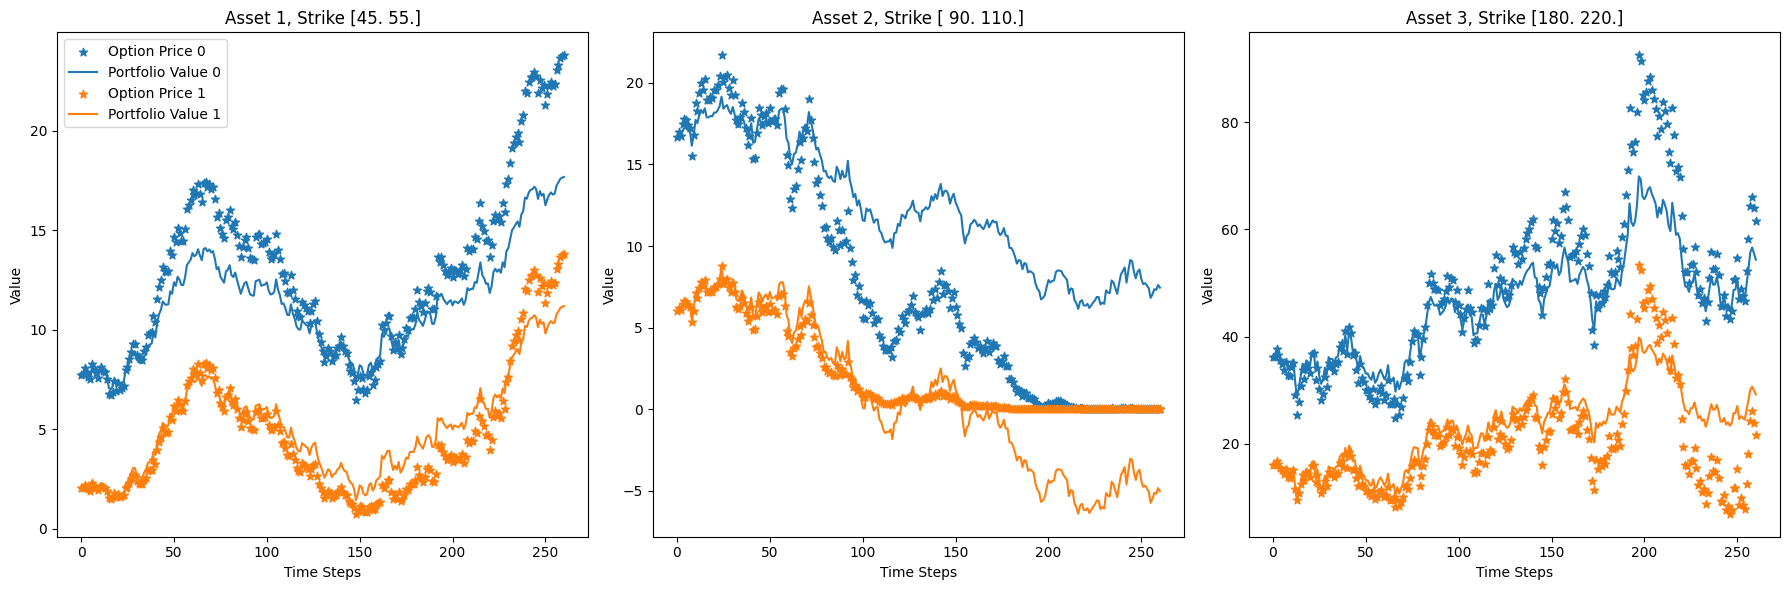

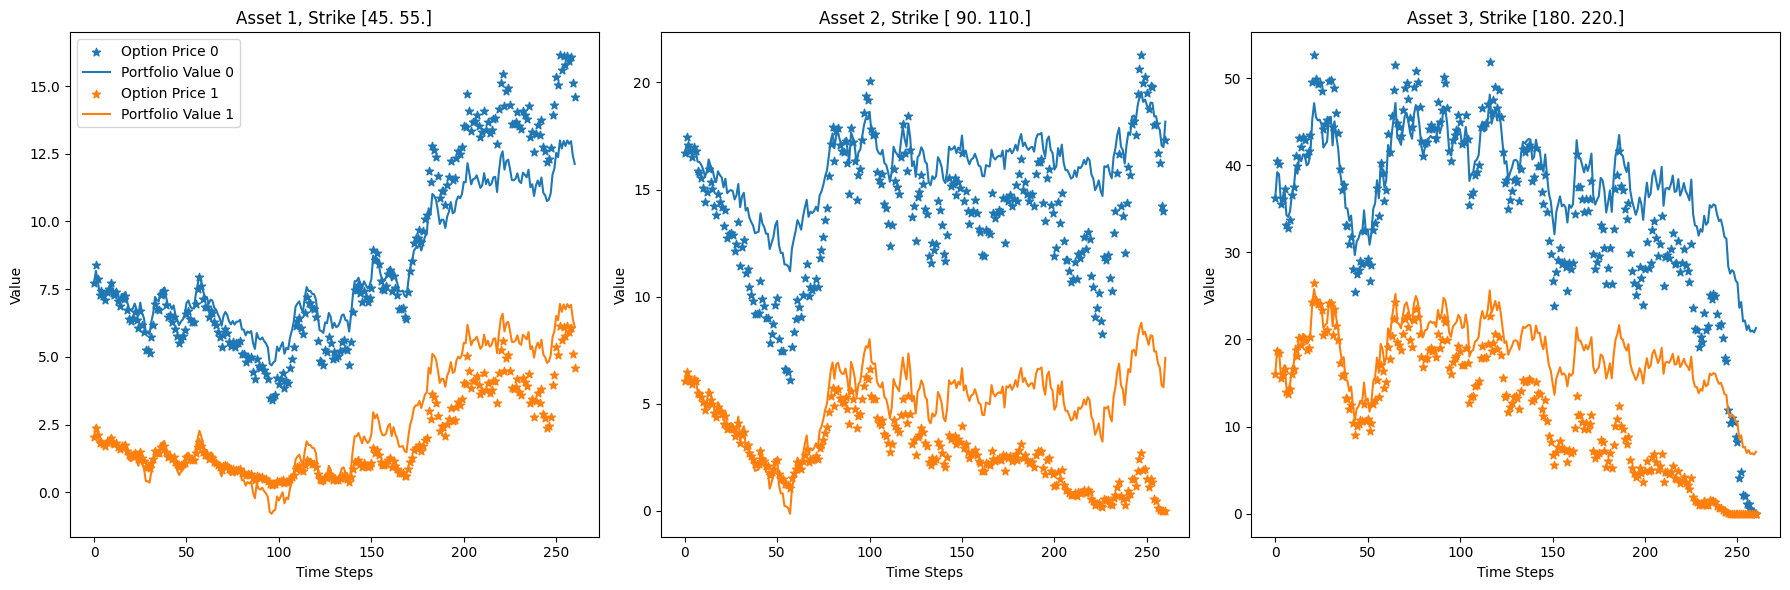

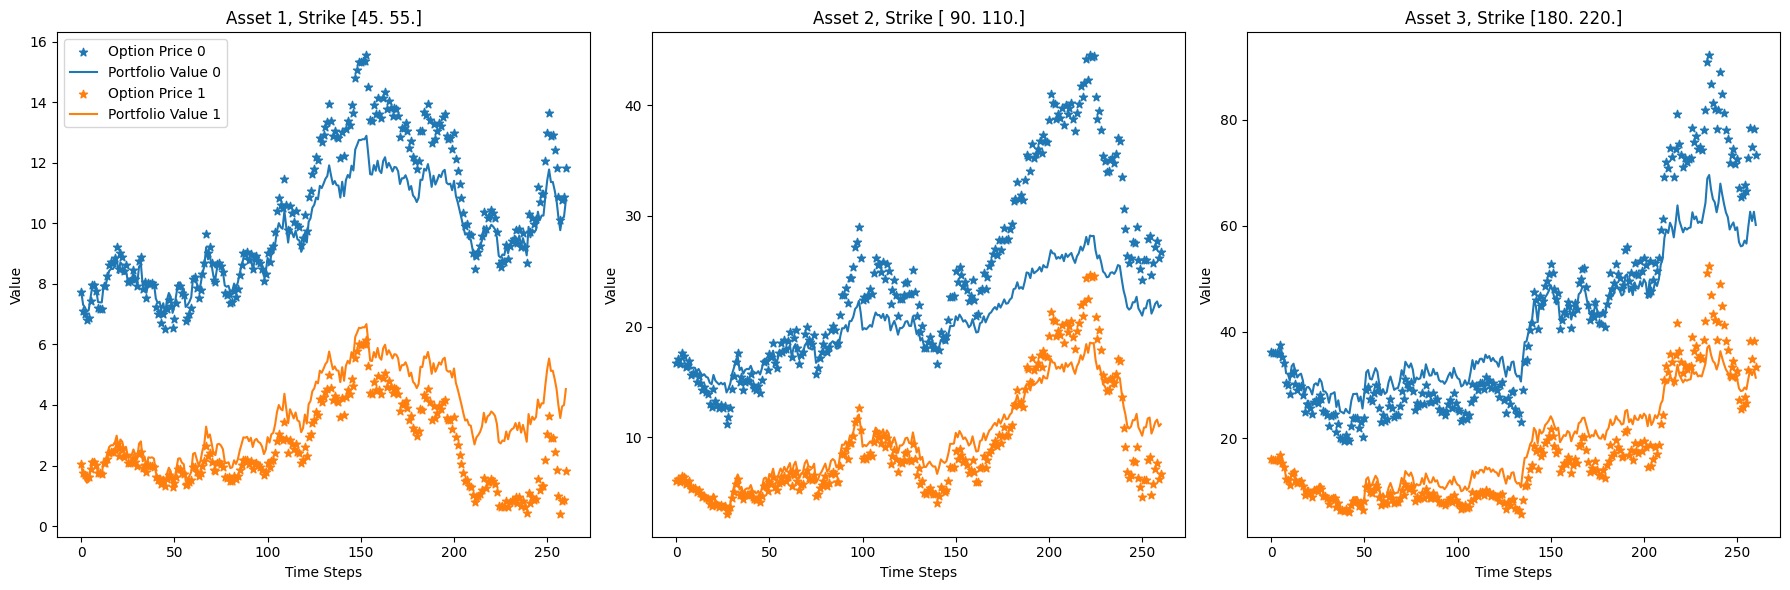

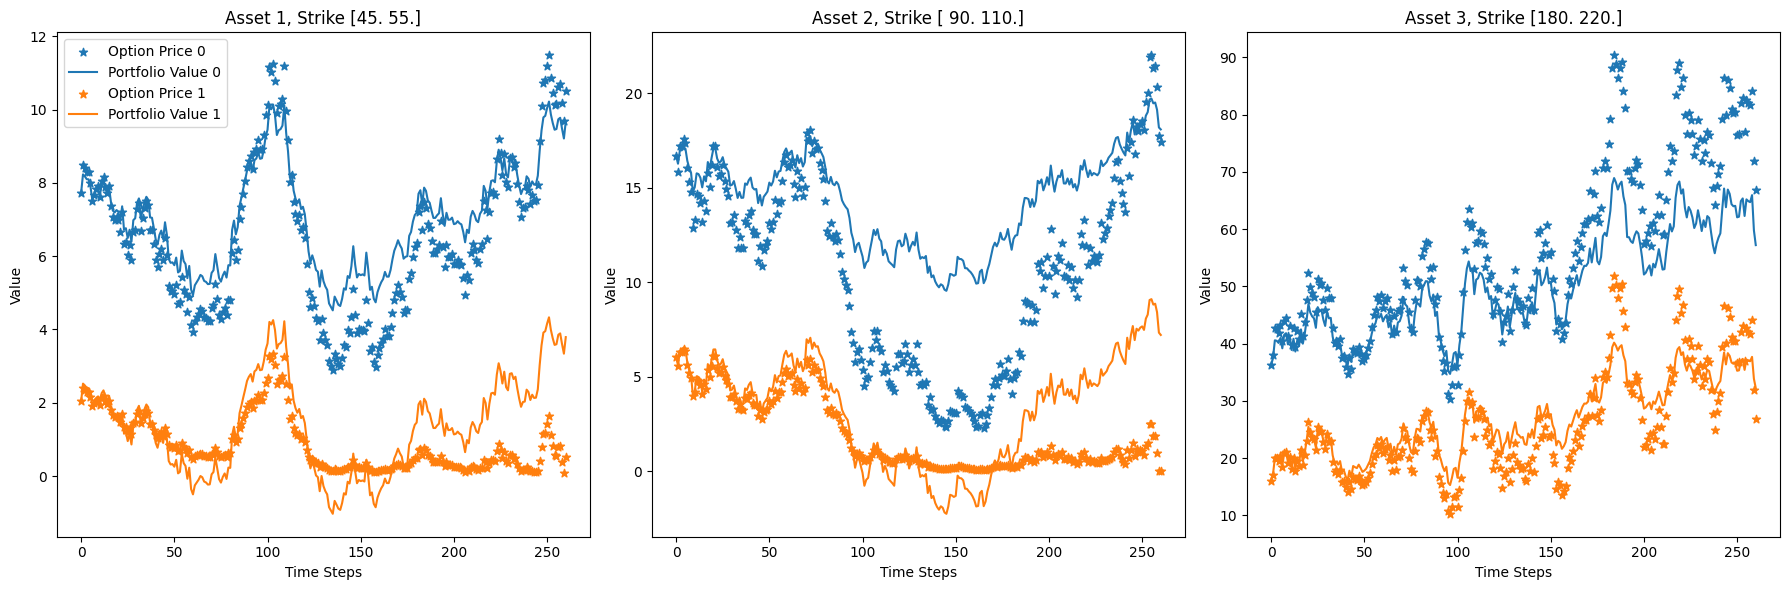

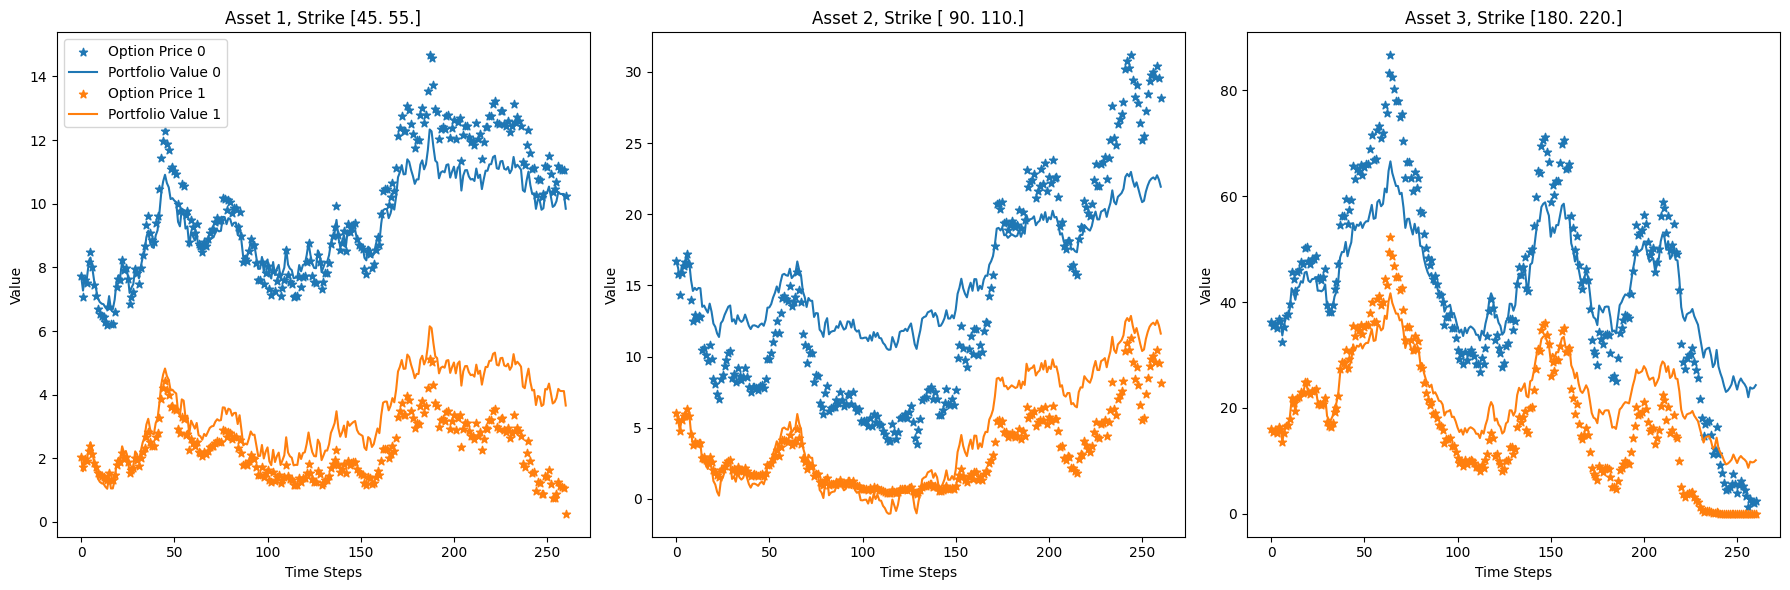

In [39]:
# train.py
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import gymnasium as gym

from environment import DeepHedgingEnv  # , device
from model import TimeSeriesTransformer
from agent import TransformerAgent

device = 'cpu'

# Market and simulation parameters
S0 = np.array([50.0, 100.0, 200.0])
K = np.array([[45.0, 55.0],
              [90.0, 110.0],
              [180.0, 220.0]])
sigma = np.array([0.15, 0.2, 0.25])
r = 0.05
num_step = 260

num_asset = len(S0)
num_strike = K.shape[1]

# Hyperparameters for the transformer model
input_dim = 6         # As used in the feature extraction (last 6 values of state)
embed_dim = 64
num_layers = 2
num_heads = 2
output_dim = num_asset * num_strike  # We want an output for each asset/strike pair
dropout_rate = 0.0
learning_rate = 0.001
num_episodes = 10000

# Create the Gymnasium environment
env = DeepHedgingEnv(S0, K, sigma, r, num_step)

# Instantiate the transformer model and agent
model = TimeSeriesTransformer(input_dim, embed_dim, num_layers, num_heads, output_dim, dropout_rate).to(device)
agent = TransformerAgent(model, device, num_asset, num_strike)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# REINFORCE training loop
episode_returns = []
for ep in range(1, num_episodes+1):
    obs, _ = env.reset()
    log_probs = []
    rewards = []
    done = False
    while not done:
        # Agent selects an action based on the current observation
        action = agent.get_action(obs)
        # For exploration add small Gaussian noise
        action = action + np.random.normal(0, 0.1, size=action.shape)
        next_obs, reward, done, truncated, info = env.step(action)
        rewards.append(reward)
        # For a proper stochastic policy you would compute the log_prob.
        # Here, we simply use the reward as a surrogate (this is a very basic REINFORCE).
        obs = next_obs
    # Since intermediate rewards are zero, the return is just the terminal reward.
    G = sum(rewards)
    episode_returns.append(G)
    loss = -G  # We want to maximize return (minimize negative return)
    optimizer.zero_grad()
    # We backpropagate through the model parameters using the surrogate loss.
    # (Note: In a full policy gradient, you would weight log probabilities by returns.)
    torch.tensor(loss, dtype=torch.float32, device=device, requires_grad=True).backward()
    optimizer.step()
    if ep % 100 == 0:
        print(f"Episode {ep}, Return: {G:.4f}")

# Evaluation: run a few episodes and record the history for plotting.
eval_episodes = 5
trajectories = []
for ep in range(eval_episodes):
    obs, _ = env.reset()
    done = False
    while not done:
        action = agent.get_action(obs)
        obs, reward, done, truncated, info = env.step(action)
    trajectories.append(env.history)

# Plotting the option prices and portfolio values for each evaluation episode.
for idx, traj in enumerate(trajectories):
    fig, axes = plt.subplots(1, num_asset, figsize=(18, 6))
    # traj["option_prices"] and traj["portfolio_values"] are lists of arrays with shape (num_asset, num_strike)
    option_prices_arr = np.array(traj["option_prices"])  # shape (num_step+1, num_asset, num_strike)
    portfolio_values_arr = np.array(traj["portfolio_values"])  # shape (num_step+1, num_asset, num_strike)
    for i in range(num_asset):
        for j in range(num_strike):
            axes[i].scatter(range(option_prices_arr.shape[0]), option_prices_arr[:, i, j],
                            marker='*', label=f'Option Price {j}' if i==0 else "")
            axes[i].plot(portfolio_values_arr[:, i, j],
                         linestyle='-', label=f'Portfolio Value {j}' if i==0 else "")
        axes[i].set_title(f'Asset {i+1}, Strike {K[i]}')
        axes[i].set_xlabel('Time Steps')
        axes[i].set_ylabel('Value')
        if i==0:
            axes[i].legend()
    plt.tight_layout()
    plt.show()
